In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

# === STEP 1: Load Data ===
df = pd.read_csv("with outliers.csv")

# Optional: Clean column names
df.columns = df.columns.str.strip().str.replace('\n', '').str.replace(' ', '_')

# === STEP 2: Prepare Target ===
target_col = "Target_Variable/Total_Income"
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df = df.dropna(subset=[target_col])
df = df.drop(columns=["Unnamed:_0"])

# === STEP 3: Select Features ===
X = df.drop(columns=[target_col, "FarmerID", "Zipcode"])
X = X.select_dtypes(include=[np.number]) 
X.shape
y = df[target_col]

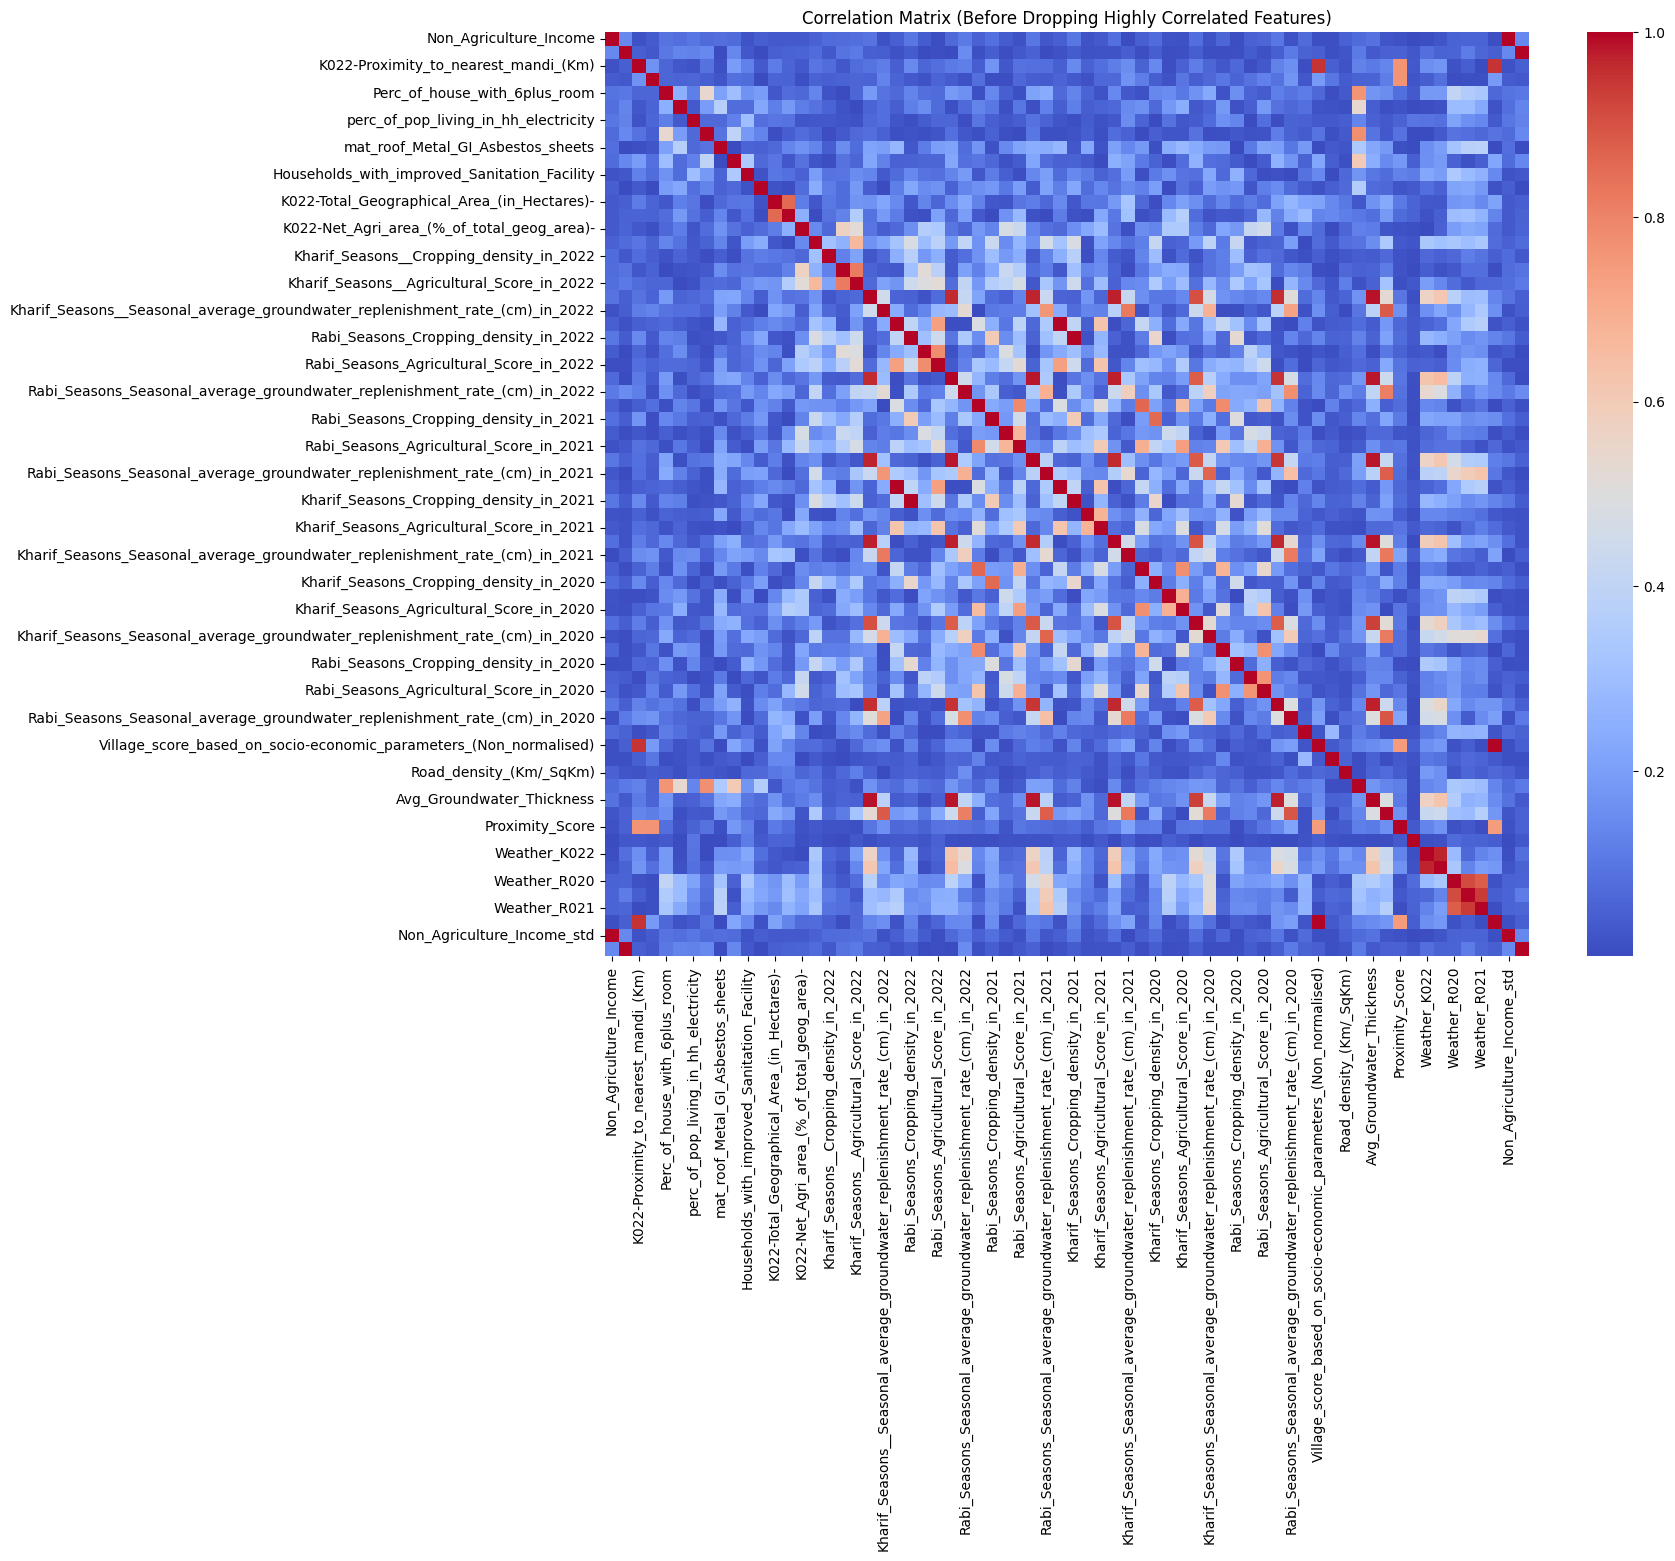


 Highly Correlated Pairs (> 0.9):
Non_Agriculture_Income ↔ Non_Agriculture_Income_std  | Correlation: 1.000
Total_Land_For_Agriculture ↔ Total_Land_For_Agriculture_std  | Correlation: 1.000
K022-Proximity_to_nearest_mandi_(Km) ↔ Village_score_based_on_socio-economic_parameters_(Non_normalised)  | Correlation: 0.951
K022-Proximity_to_nearest_mandi_(Km) ↔ Village_Dev_Score  | Correlation: 0.951
Kharif_Seasons__Seasonal_average_groundwater_thickness_(cm)_in_2022 ↔ Rabi_Seasons_Seasonal_average_groundwater_thickness_(cm)_in_2022  | Correlation: 0.965
Kharif_Seasons__Seasonal_average_groundwater_thickness_(cm)_in_2022 ↔ Rabi_Seasons_Seasonal_average_groundwater_thickness_(cm)_in_2021  | Correlation: 0.972
Kharif_Seasons__Seasonal_average_groundwater_thickness_(cm)_in_2022 ↔ Kharif_Seasons_Seasonal_average_groundwater_thickness_(cm)_in_2021  | Correlation: 0.975
Kharif_Seasons__Seasonal_average_groundwater_thickness_(cm)_in_2022 ↔ Kharif_Seasons_Seasonal_average_groundwater_thickness_(cm)_i

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Compute and Plot Correlation Matrix ===
corr_matrix = X.corr().abs()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, square=True)
plt.title("Correlation Matrix (Before Dropping Highly Correlated Features)")
plt.show()

# === 2. Upper Triangle of Correlation Matrix ===
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# === 3. List Highly Correlated Pairs ===
threshold = 0.9
high_corr_pairs = [(col1, col2, upper.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.index
                   if upper.loc[col1, col2] > threshold]

# Print them
print("\n Highly Correlated Pairs (> 0.9):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} ↔ {col2}  | Correlation: {corr_val:.3f}")

# === 4. Identify Columns to Drop ===
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

print(f"\n Columns Dropped (due to correlation > {threshold}):")
print(to_drop)

# === 5. Drop the Columns ===
X_reduced = X.drop(columns=to_drop)


In [15]:
X_reduced.shape

(28622, 53)

In [16]:
# === STEP 4: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# === STEP 5: Train XGBoost ===
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# === STEP 6: Predict and Evaluate ===
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Accuracy: {(1 - mape) * 100:.2f}%")


Mean Absolute Percentage Error (MAPE): 0.2161
Accuracy: 78.39%


In [17]:
import shap

# Create SHAP explainer for XGBoost
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)


 98%|===================| 5582/5725 [00:18<00:00]        

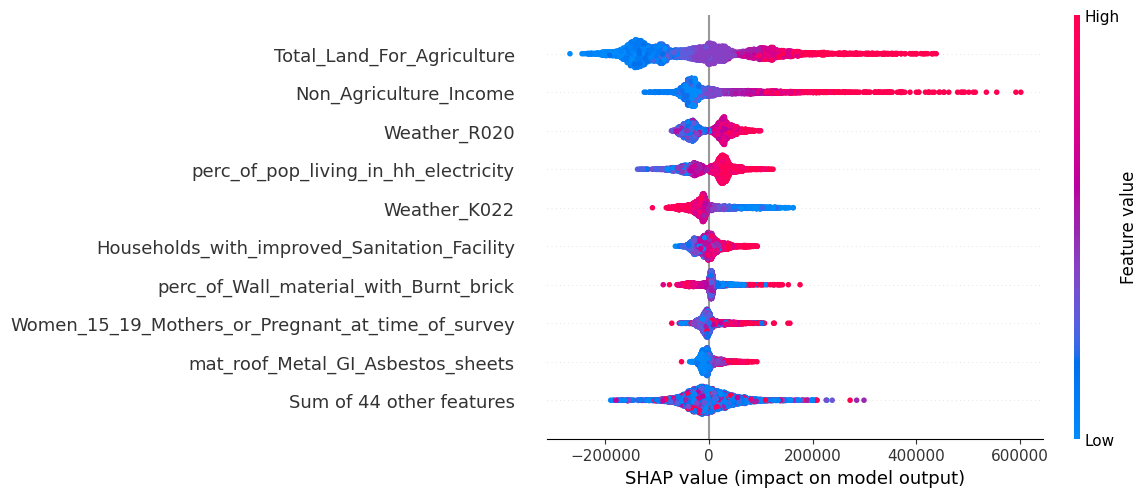

In [18]:
shap.plots.beeswarm(shap_values)


| Rank | Feature                                                       |Inference 
| 1️⃣  | **Total\_Land\_For\_Agriculture**                              | More land → higher SHAP value → strongly increases income. Blue dots (low land) shift left; pink dots (more land) shift right.                   |
| 2️⃣  | **Non\_Agriculture\_Income**                                   | Higher non-agri income (pink) also increases overall income. Low values (blue) reduce predicted income.                                          |
| 3️⃣  | **Weather\_R020**                                              | Complex effect: both high and low values influence predictions, indicating weather variability significantly affects income.                     |
| 4️⃣  | **perc\_of\_pop\_living\_in\_hh\_electricity**                 | Higher electrification (pink) → higher predicted income. Suggests access to electricity correlates with better earnings.                         |
| 5️⃣  | **Weather\_K022**                                              | Similar to Weather\_R020, some weather pattern around Kharif season seems to strongly influence income (pink = higher rainfall or temperature?). |
| 6️⃣  | **Households\_with\_improved\_Sanitation\_Facility**           | Better sanitation (pink) appears to positively impact income, showing a likely quality-of-life connection.                                       |
| 7️⃣  | **perc\_of\_Wall\_material\_with\_Burnt\_brick**               | Indicates that well-constructed homes (burnt bricks) are found in higher-income areas.                                                           |
| 8️⃣  | **Women\_15\_19\_Mothers\_or\_Pregnant\_at\_time\_of\_survey** | More such cases (pink) seem to slightly reduce predicted income — possible socioeconomic or health-related factors.                              |
| 9️⃣  | **mat\_roof\_Metal\_GI\_Asbestos\_sheets**                     | Possibly a proxy for poor housing. High values (pink) tend to reduce predictions slightly.                                                       |


i)Land ownership, non-farm income, and weather are the most dominant drivers.
ii)Infrastructure indicators like electrification and sanitation also play a crucial role.
iii)Social indicators, such as teenage pregnancy or household construction material, signal deeper structural inequalities impacting income.